In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as scp
import nltk
import imageio
import sklearn

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.svm import SVR
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn import metrics 
from sklearn.metrics import pairwise_distances 

from timeit import default_timer as timer
%matplotlib inline

import json as js

- Reverse PCA
- polish this stuff
- make python scrips
- make readme nice

# Project
### Stages

- 4x20x10000 stuctures with 19-30 atoms in a cluster
    - coordinates
    - dipole moment
    - energy
- Goals
    - End user
        - Configuration Sampling 
            - Find one structure with the lowest energy
    - Eliminate redundant structures
    - Find descriptors
        - reduce dimensions
    

# The Data

To use this you should provide:  
- the **path** to your XTB-data
- the **name** for your data

> The name will be used to name the folder where data produced by this code is put

In [98]:
!pwd

/Users/matijaas/Documents/GitHub/ClusterDataIDS/JupyterNotebook


In [99]:
project_folder = "/Users/matijaas/Documents/GitHub/ClusterDataIDS/"

In [ ]:
xtb_folder = project_folder + 

In [96]:
theName = str(input("Your data will be in:"))

Your data will be in: test_data


In [97]:
!echo $theName

test_data


In [100]:
path2csv = project_folder + "{}/Data_Collection.csv".format(theName)
path2csv

'/Users/matijaas/Documents/GitHub/ClusterDataIDS/test_data/Data_Collection.csv'

In [7]:
pwd = !pwd
pwd.nlstr

'/Users/matijaas/Documents/GitHub/ClusterDataIDS/JupyterNotebook'

In the notebook user specifies the path of where the XTB data is and what is the name of the data (for the folder)

In python scripts the user is promted about where the XTB data is 

# How to Cluster

#### Read data in

Data must have a `.csv`-file that contains:  
Header row: ``` Filename,LogPath,XYZPath,Dipole,Energy ```


| Filename | LogPath | XYZPath | Dipole| Energy |
|------|------|------|------|------|
| Name of the cluster | path to .log-file | path to .xyz-file | Dipole moment value | Energy value |

> Here we either require the .log-file or remove it from the code

#### Make the csv-file 
> Instructions how to make the .csv-file from the actual data using the script

#### Run these cells with ```shift+enter```

In [8]:
def init_DF(csvfile):
    "Reads a xyz-file and initializes the dataframe."
    
    filescsv = pd.read_csv(csvfile)                    # Read tthe .csv-file to a DataFrame
    xyz_temp = filescsv.iloc[0,2]                      # Get one .xyz-file as a reference
    
    xyz_test = read_xyz(xyz_temp,flatten=False)        # Read coordinates to a DF (no flattening)
    
    #filenames = filescsv.iloc[:,0]                    # Get the names for files as a Series (This one not used here)
    n_atoms = xyz_test.index.size                      # Number of atoms from the reference .xyz-file
    atomnames = np.array(xyz_test.index)               # Names of all the atoms as ndarray
    
    list_atomnames = []
    for i,j in enumerate(atomnames):                   # Give numbers for the atoms
        list_atomnames.append("{}_{}".format(j,i))
    arr_atomnames = np.array(list_atomnames)           # Enumerated atomnames as an ndarray
    
    col_names = makeMultiIndexs(arr_atomnames)         # Make column names (multi-index)

    arr_clusters,filenames = init_xyz_array(filescsv,n_atoms) # Read the actual coordinate data
    
    coord_df = pd.DataFrame(arr_clusters,index=filenames,columns=col_names) # Save the data in nice DF-fornat
    
    
    return coord_df

In [9]:
def init_xyz_array(filecsv, n_atoms):
    """Reads .xyz-file paths from .csv-file and returns 
    an array with all xyz-coords in rows, and the filenames for DF indexes"""
    
    arr_clusters = np.zeros((1,3*n_atoms+2))             # cols of coord array should be of shape [clusters,atoms*[x,y,z]]
    filenames = np.array(filecsv.Filename)               # Get the names of the clusters from the .csv-file

    for index, row in filecsv.iterrows():                # Iterate through clusters and save their attributes
        dipole = row.Dipole                              # find the dipole value
        energy = row.Energy                              # find the energy value
        metarr = np.array([energy,dipole])               # put dipole and energy to an array
        path = row.XYZPath                               # find the path for .xyz-file
        xyzs = read_xyz(path)                            # Read coordinates to an ndarray with flatten=True (default)

        #if index == None:                               # print stuff for debugging purposes of this function
        #    print("Filename:",filename)
        #    print("metarr:",metarr)
        #    print("shape:",metarr.shape)
        #    print("type:",type(metarr))
        #    print("path:",path)
        #    print("coordshape:",xyzs.shape)
        #    print("coords:",xyzs)
        
        arrr = np.array(list(metarr)+list(xyzs))         # concatenate one cluster info
        arr_clusters = np.vstack((arr_clusters,arrr))    # concatenate clusters to one array
    return arr_clusters[1:,:], filenames

In [10]:
def read_xyz(xyzfile,flatten=True):
    """
    usage: read_xyz(xyzfile,flatten(Default=True))
    
    Reads a xyz-file and returns the coordinates as DF
    or flattened to a Numpy-array
    """
    xyz_temp = pd.read_csv(xyzfile, \
                       sep='\s+', \
                       skiprows=2, \
                       header=None, \
                       index_col=0, \
                       names=['x','y','z']\
                      ).sort_index(ascending=False)       # Reads coordinates from an xyz-file
    
    atoms3 = xyz_temp.shape[0]*3                          # multiply n of atoms with 3 dimensions
    
    if flatten==True:
        xyz_flat = xyz_temp.values.flatten().reshape(1,atoms3)#.astype(np.float)
        return xyz_flat[0]                                # returns coordinates as ndarray of shape [1,atoms*3]
    else:
        return xyz_temp                                   # returns coordinates as a DF

In [11]:
def makeMultiIndexs(arr):
    """
    Gets names of atoms as array and makes a pandas multi-indexing structure
    with x-, y- and z- columns for each atom.
    """
    top_arr = np.empty((arr.size * 3 +2)).astype(str)
    top_arr[0] = "Properties"
    top_arr[1] = "Properties"
    top_arr[2::3] = arr
    top_arr[3::3] = arr
    top_arr[4::3] = arr
    butt_arr = np.empty((arr.size * 3 +2)).astype(str)
    butt_arr[0] = "Energy"
    butt_arr[1] = "Dipole"
    butt_arr[2::3] = "x"
    butt_arr[3::3] = "y"
    butt_arr[4::3] = "z"
    col_arr = np.vstack((top_arr,butt_arr))
    #col_arr.transpose()
    col_arr_tuples = list(zip(*col_arr))
    col_names = pd.MultiIndex.from_tuples(col_arr_tuples, names=["Atom","Coord"])
    return col_names

In [12]:
clusters_df = init_DF(path2csv)

In [13]:
#from multi-index to one index
clusters_df.columns = ['_'.join(col) for col in clusters_df.columns.values]

## Data exploration / EDA

We start by looking at the correlation among our variables. The correlation betwwen two variables is a measure of the linear dependecy among them:
$$ Cor(X,Y)=\frac{Cov(X,Y)}{\sqrt{Var(X)Var(Y)}}$$
In order to apply a linear model to predict the energy wrt the other variables, is important to check that there is a small correlation  between the variables we are using as predictors, since we will predict the response by an approprate linear combination of the predictors. In our data, there is no particoularly high correlation.

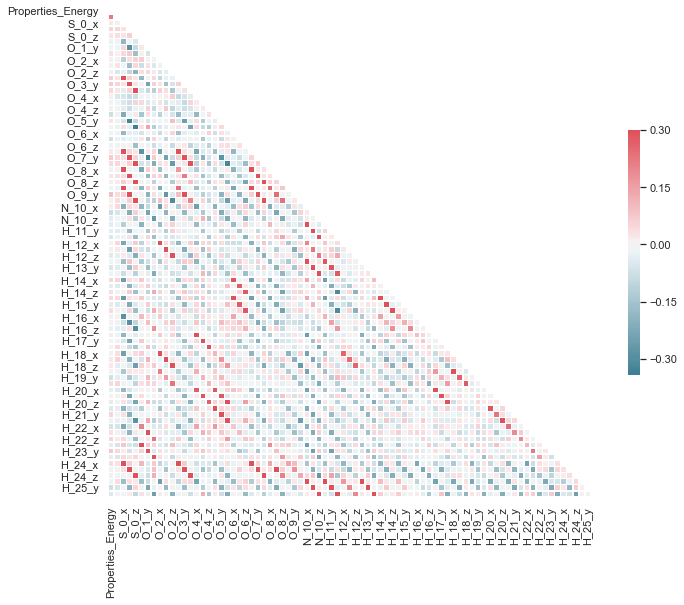

In [14]:
sns.set(style="white")

# Compute the correlation matrix
corr = clusters_df.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11,9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

The correlations among data are not really high, hence we can consider all of hem as independent variables.   
Having a look on the distributions of the energy variable, it is asymmetric, with a tail on the right. 

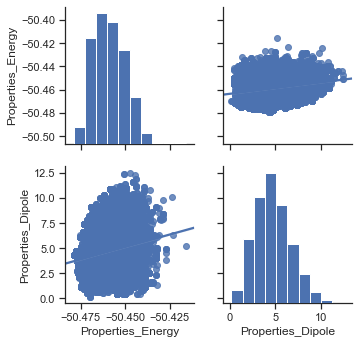

In [15]:
sns.set(style="ticks", color_codes=True)
sns.pairplot(clusters_df,  kind="reg",vars=['Properties_Energy','Properties_Dipole'])

Energy and dipole don't have significant correlation

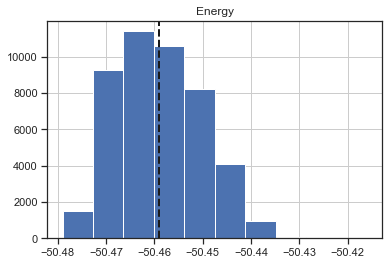

In [16]:
clusters_df['Properties_Energy'].hist()
plt.title("Energy")
plt.axvline(np.mean(clusters_df['Properties_Energy']), color='k', linestyle='dashed', linewidth=2)

Difference between min and max energies is very small

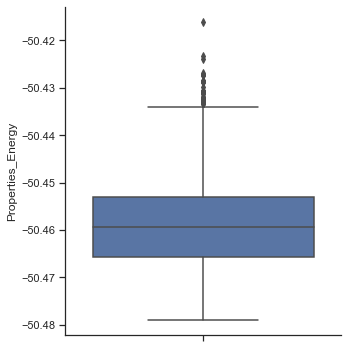

In [17]:
sns.catplot( y="Properties_Energy", kind="box", data=clusters_df)

The algorithm in ABCluster tries to make the energies as small as possible hich can be seen here

In [18]:
energy=clusters_df['Properties_Energy'] # %1 should take only the decimals but does it?
coord=clusters_df.drop(['Properties_Energy','Properties_Dipole'],1) # dipoles and energy out

## Linear regression

In statistics we define as "supervised learning" the set of models that are ment to evaluate an output $y$ (answer variable) as a function of a set of known indipendent variables taken as input $(X_1,...,X_k)$ .   
Furthermore, if we assume that $Y$ has a known probability law, we use parametric models. When $Y$ is a continuous variable, the mainly used model is the regression, that is a method that allows to estimate the conditional average of the answer $ E (Y | X_1 = x_1, ..., X_k = x_k) $ or its transformed as a linear combination of the explanatory $\eta=X '\beta $.
We have a simple linear regression, when using a model of the type:
$$ Y_i = x_i '\beta + \varepsilon_i $$ with $i = 1, ..., n $ number of observations, such that $ n> k $. Equivalently, in compact form:
$$ Y = X \beta + \varepsilon $$ where $ Y_ {nx1} = (Y_1, ..., Y_n) '$ is the vector of n v.c. of independent outputs, $ X_ {nx (k + 1)} $ is the matrix of the drawing, which together with the vector of coefficients $ \beta = (\beta_0, ..., \beta_k) '$ constitutes the deterministic component of the model, while $ \varepsilon = (\varepsilon_1, ..., \varepsilon_n) '$ is the erratic component, where $ \varepsilon_i \sim N (0, \sigma ^ 2 _ {\varepsilon}) $ for each $ i $ are unknown errors with zero mean and constant variance.

We can implement a linear regression model to predict the energy ($y$) of our cluster with rrespect to the coordinates variables ($X$). As we saw above, our response takes all values around -40.9, what makes the difference is the centesimal portion, hence we will focus our attention on predicting this part.


In [19]:
#divide the dataset in train and test

x_train,x_test,y_train,y_test = train_test_split(coord,energy,test_size=0.20)

In [20]:
#linear regression model on train set

model = LinearRegression()
model.fit(x_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [21]:
#model.coeff
r_sq = model.score(x_train, y_train)
r_sq #pretty bad

0.06743034159231409

In [22]:
#predict from the test
y_pred = model.predict(x_test)
pred_test = pd.DataFrame({'Actual': y_test.values.flatten(), 'Predicted': y_pred.flatten()})
pred_test.head(6)

,Actual,Predicted
0,-50.462458,-50.457606
1,-50.467155,-50.459576
2,-50.458998,-50.461246
3,-50.458816,-50.462413
4,-50.469195,-50.462519
5,-50.456123,-50.460735


In [23]:
#divide the dataset in train and test

coord_train,coord_test,energy_train,energy_test = train_test_split(coord,energy,test_size=0.20)

In [24]:
#linear regression model on train set

model = LinearRegression()
model.fit(coord_train, energy_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [25]:
#model.coeff
r_sq = model.score(coord_train, energy_train)
r_sq #pretty bad

0.06720264588646485

Linear regression works poorly which means that the conformation in general doesn't correlate with the energy

In [26]:
#predict from the test
energy_pred = model.predict(coord_test)
predictions = pd.DataFrame({'Actual': energy_test.values.flatten(), 'Predicted': energy_pred.flatten()})
predictions.head(6)

,Actual,Predicted
0,-50.471910,-50.460072
1,-50.469195,-50.463057
2,-50.442617,-50.457339
3,-50.468587,-50.460427
4,-50.468271,-50.455107
5,-50.471328,-50.461656


### Linear Regression with Feature selection

In [27]:
#feature selection alternative
#https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html

estimator = SVR(kernel="linear")
selector = RFE(estimator, 5, step=1)
selector = selector.fit(coord_train, energy_train)
#print(selector.support_) 
print(selector.ranking_)

[74 73 72 71 70 69 68 67 66 65 64 63 62 61 60 59 58 57 56 55 54 53 52 51
 50 49 48 47 46 45 44 43 42 41 40 39 38 37 36 35 34 33 32 31 30 29 28 27
 26 25 24 23 22 21 20 19 18 17 16 15 14 13 12 11 10  9  8  7  6  5  4  3
  2  1  1  1  1  1]


> But what is this then selecting?

In [28]:
coord_train.columns

Index(['S_0_x', 'S_0_y', 'S_0_z', 'O_1_x', 'O_1_y', 'O_1_z', 'O_2_x', 'O_2_y',
       'O_2_z', 'O_3_x', 'O_3_y', 'O_3_z', 'O_4_x', 'O_4_y', 'O_4_z', 'O_5_x',
       'O_5_y', 'O_5_z', 'O_6_x', 'O_6_y', 'O_6_z', 'O_7_x', 'O_7_y', 'O_7_z',
       'O_8_x', 'O_8_y', 'O_8_z', 'O_9_x', 'O_9_y', 'O_9_z', 'N_10_x',
       'N_10_y', 'N_10_z', 'H_11_x', 'H_11_y', 'H_11_z', 'H_12_x', 'H_12_y',
       'H_12_z', 'H_13_x', 'H_13_y', 'H_13_z', 'H_14_x', 'H_14_y', 'H_14_z',
       'H_15_x', 'H_15_y', 'H_15_z', 'H_16_x', 'H_16_y', 'H_16_z', 'H_17_x',
       'H_17_y', 'H_17_z', 'H_18_x', 'H_18_y', 'H_18_z', 'H_19_x', 'H_19_y',
       'H_19_z', 'H_20_x', 'H_20_y', 'H_20_z', 'H_21_x', 'H_21_y', 'H_21_z',
       'H_22_x', 'H_22_y', 'H_22_z', 'H_23_x', 'H_23_y', 'H_23_z', 'H_24_x',
       'H_24_y', 'H_24_z', 'H_25_x', 'H_25_y', 'H_25_z'],
      dtype='object')

With only 2 hydrogens the $R^2$ value is smaller than with all the atoms

In [29]:
#oxigen O8 seems the most significant variable in our model
model1 = LinearRegression().fit(x_train.loc[:,('H_17_x','H_17_y','H_17_z','H_18_x','H_18_y','H_18_z')], y_train) #select the most significant variables...
print('R2 simple reg',model1.score(x_train.loc[:,('H_17_x','H_17_y','H_17_z','H_18_x','H_18_y','H_18_z')], y_train))

R2 simple reg 0.0017123820433995185


With all the other atoms than hydrogens:

In [30]:
coord_train.iloc[:5,:33]

,S_0_x,S_0_y,S_0_z,O_1_x,O_1_y,O_1_z,O_2_x,O_2_y,O_2_z,O_3_x,...,O_7_z,O_8_x,O_8_y,O_8_z,O_9_x,O_9_y,O_9_z,N_10_x,N_10_y,N_10_z
20885,1.185153,1.885591,1.398535,0.867602,-2.143216,-0.114804,1.641816,-0.060066,-1.341837,0.961489,...,2.145318,-0.022516,2.090722,0.635699,2.356633,1.574607,0.606118,-0.748807,-0.738166,1.494806
14316,-0.159859,1.950492,-0.856945,0.117510,-2.499414,0.227789,-1.106080,-1.482014,-1.935224,0.393770,...,-0.881879,0.308778,0.748173,-1.532753,-0.508697,-0.137539,1.709857,-2.503457,-0.237757,-0.146733
11026,1.869652,-0.774520,-0.200340,-0.339528,-2.872277,0.892992,-2.214618,-0.932768,0.762865,0.963600,...,-0.285425,1.480557,-0.793230,1.188775,2.072319,0.558887,-0.734985,-0.557368,2.767251,0.691878
26804,-0.076291,-1.667340,-1.074089,-1.991087,-0.634186,1.215271,-0.869290,2.113488,1.059979,1.186565,...,-2.515905,-1.066884,-0.582497,-1.205686,-0.572664,-2.729947,-0.254010,0.582592,-0.918251,1.961282
18928,1.221190,-1.471011,0.097361,0.136654,1.944717,1.684765,-1.494492,-0.021259,1.316166,1.064177,...,0.708602,2.272761,-1.382667,1.084735,-0.272861,2.010777,-1.138367,-1.136662,-1.857291,-2.065424


In [31]:
# omit hydrogens
model2 = LinearRegression().fit(coord_train.iloc[:,:33], energy_train) #select the most significant variables...
print('R2 simple reg',model2.score(coord_train.iloc[:,:33], energy_train))

R2 simple reg 0.039585835481679044


## Principal Component Analysis
The PCA is a tool used to reduce the dimensionality of the data.
It tries to preserve as much information as possible.  
These two goals in PCA are pursued by means of a transformation of the original variables into new variables, called Principal Components (PCs).  
They consists of a linear combination of the original variables.
PCs are uncorrelated and arranged in order of decreasing variance, so that the first PCs account for most of the variation in the sample.   

Assuming we want to reduce the number of our original p variables to $k<p$ variables, the PCA method can be formalized as follows:  
• 1st PC: determine the coeffcients of the linear combination
$$Z_{1j} = a_1^T X = \sum_{i=0}^p a_{1i} X_i $$ 
that maximize $ Var(Z_1) = a_1^T \Sigma a_1 $ under the constraint $ a_1^T a_1 = 1 $   

> The formula $ Var(Z_1) = a_1^T \Sigma a_1 $ looks weird

• 2nd PC: determine coeffcients of the linear combination
$$ Z_{2j} = a_2^T X = \sum_{i=0}^p a_{2i} X_i $$
that maximize $ Var(Z_2) = a_2^T \Sigma a_2$ under the constraint $ a_2^T a_2=1$ and $Cov(Z_1,Z_2)=0$   

• proceed in a similar fashion for all other components.   

• Final output: $Z_1, \dots ,Z_p $such that $Var (Z1) > Var (Z2) > \dots > Var (Zp)$ and $cov(Zj ; Zk ) = 0$ for $j \neq k$  

We will apply PCA to our coordinates variable, in order to select new variables, that explain at least 80% of the variability of our data.

In [32]:
pca = PCA(n_components=0.8,svd_solver='full')   # from docstring: this should include PCs so that 80% of variance is explained
PCs_coord = pca.fit_transform(coord)            # fit_transform ehkä normalisoi
PCs_df = pd.DataFrame(data = PCs_coord, columns=["PC{}".format(i) for i in range(PCs_coord.shape[1])])
print('Explained variance :', np.sum(pca.explained_variance_ratio_)*100, '%')    # It seems that it is 80% :D

Explained variance : 80.21909698485128 %


Explained variance PC1 : 5.758731955517278 %
Explained variance PC2 : 5.449759951285701 %


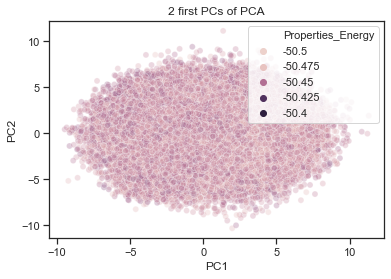

In [33]:
#2D graph of first two PCs
print('Explained variance PC1 :', pca.explained_variance_ratio_[0]*100, '%')
print('Explained variance PC2 :', pca.explained_variance_ratio_[1]*100, '%')

sns.scatterplot(x=PCs_df['PC1'], y=PCs_df['PC2'], hue=energy,  alpha=0.3)
plt.title("2 first PCs of PCA")
plt.ylabel('PC2')
plt.xlabel('PC1')
plt.show()

> Here $\uparrow$ could be some clustering seen but the representation is poor (cartesian coordinates)

## K-means / Clustering
In order to reduce the variety of our observations we are clustering our data, by using a k-mean algorith.  
This algorithm is a non-hierarchical methods of clustering, i.e. we assume the number $ k $ of groups is assumed to be fixed.
Algorithm introduced by MacQueen (1967): each statistical unit is assigned to the cluster whose centroid (i.e. vector of means) is the closest one. The metric used to measure the distance among groups is typically the Euclidean one.

1. Initial partition into K clusters, (possibly randomly generated)
2. For each of the K clusters, compute the cluster centroid.
3. Assign each observation to the cluster whose centroid is closest
4. Recompute centroids for all clusters
5. Repeat 3. - 4. until reaching a maximum number of iterations or when it is not possible to redistribute observations

In order to chose the optimal number of groups, a good criteria is to find a balance between low within-cluster variation $WSS$ and number of groups.  
We start by clustering our original dataset, a clustering of the PCs dtaset is also shown.

#### Energy and dipole

In [34]:
kmeans_ED = KMeans(n_clusters=4)  #we should choose the number of clusters
kmeans_ED.fit(clusters_df) 
ED_kmeans_res = kmeans_ED.predict(clusters_df)

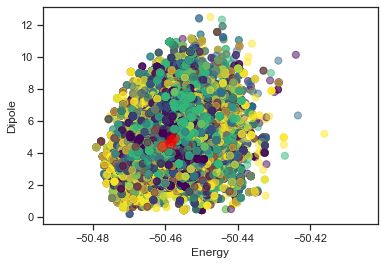

In [35]:
plt.scatter(clusters_df['Properties_Energy'], clusters_df['Properties_Dipole'], c=ED_kmeans_res,s=50, cmap='viridis', alpha=0.5)
centers_ED = kmeans_ED.cluster_centers_
plt.scatter(centers_ED[:, 0], centers_ED[:, 1], c='red', s=100, alpha=0.5)
plt.xlabel('Energy')
plt.ylabel('Dipole')
plt.show()

In [36]:
PCsE_df = pd.concat([PCs_df, clusters_df[['Properties_Energy']]], axis = 1)  
#finalDf = pd.concat([finalDf, clusters_df[['Properties_Dipole']]], axis = 1) # leave dipoles out

#### Coordinates as PCs

In [37]:
#clustering using PCS as variables
kmeans_PCs = KMeans(n_clusters=23)
kmeans_PCs.fit(PCs_df)
PCs_kmeans = kmeans_PCs.predict(PCs_df)

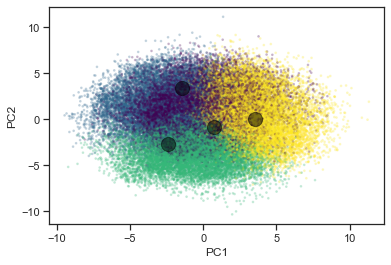

In [38]:
plt.scatter(PCs_df['PC1'], PCs_df['PC2'], c=PCs_kmeans,s=3, cmap='viridis', alpha=0.2)
centers_PCs = kmeans_PCs.cluster_centers_
plt.scatter(centers_PCs[:, 0], centers_PCs[:, 1], c='black', s=200, alpha=0.5)
plt.ylabel('PC2')
plt.xlabel('PC1')
plt.show()

**PCA reversed**

In [94]:
mu = np.mean(coord,axis=0)
pca_rev = np.dot(centers_PCs,pca.components_)
for i in range(pca_rev.shape[0]):
    pca_rev[i,:] += mu
# this is then the coordinates of the centers

#### Coordinates as PCs and Energy

In [39]:
#clustering using PCS+E as variables
kmeans_PCE = KMeans(n_clusters=23)
kmeans_PCE.fit(PCsE_df)
PCE_kmeans = kmeans_PCE.predict(PCsE_df)

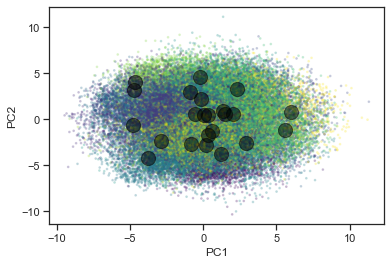

In [40]:
plt.scatter(PCsE_df['PC1'], PCsE_df['PC2'], c=PCE_kmeans,s=3, cmap='viridis', alpha=0.2)
centers_PCE = kmeans_PCE.cluster_centers_
plt.scatter(centers_PCE[:, 0], centers_PCE[:, 1], c='black', s=200, alpha=0.5)
plt.ylabel('PC2')
plt.xlabel('PC1')
plt.show()

#### Search for optimal k = amount of clusters

In [41]:
k_values = np.arange(3,40)
ch_values = np.empty(k_values.shape)


In [42]:
for k in k_values:
    kmeans_model = KMeans(n_clusters=k,random_state=1)
    kmeans_model.fit(PCsE_df)
    labels = kmeans_model.labels_
    ch_values[k-k_values[0]] = metrics.calinski_harabasz_score(PCsE_df,labels)

In [43]:
k_best = k_values[np.where(ch_values == ch_values.max())[0][0]]

In [44]:
#clustering using PCS+E as variables with best k-value
kbest_PCE = KMeans(n_clusters=k_best)
kbest_PCE.fit(PCsE_df)
PCE_kbest = kbest_PCE.predict(PCsE_df)

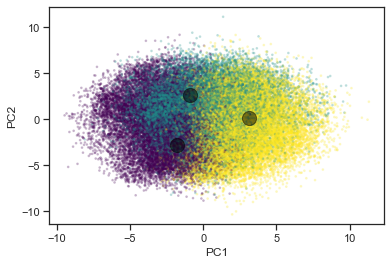

In [45]:
plt.scatter(PCsE_df['PC1'], PCsE_df['PC2'], c=PCE_kbest,s=3, cmap='viridis', alpha=0.2)
centers_kbest = kbest_PCE.cluster_centers_
plt.scatter(centers_kbest[:, 0], centers_kbest[:, 1], c='black', s=200, alpha=0.5)
plt.ylabel('PC2')
plt.xlabel('PC1')
plt.show()

In [46]:
labels_PCE = kmeans_PCE.labels_
metrics.calinski_harabasz_score(PCsE_df,labels_PCE)

848.9093119339661

#### t-SNE for visualization

In [47]:
tsne_PCE = TSNE(n_components=2).fit_transform(PCsE_df)    # make t-SNE magic happen

In [48]:
#centers_tSNE = TSNE(n_components=2).fit_transform(centers_PCE)  # Same for centers which doesn't work

```python
tsne = TSNE(n_components=2)
tsne_PCE = tsne.fit_transform(PCsE_df)
centers_tSNE = tsne.fit_transform(centers_PCE)
```
> Does this the same as upper?

In [49]:
tsne_PCE_cluster = pd.concat((pd.DataFrame(tsne_PCE,columns=['tsne1','tsne2']), pd.DataFrame(PCE_kmeans,columns=['groupID'])), axis = 1)  
# combine t-SNE info with the info of the cluster

In [50]:
centers_tSNE = tsne_PCE_cluster.groupby(by='groupID').mean()
# calculate the centers as means

In [51]:
!say "The code is ready"

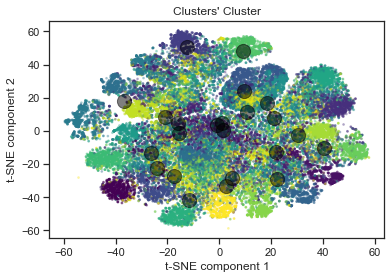

In [52]:
plt.scatter(tsne_PCE[:,0],tsne_PCE[:,1], c=PCE_kmeans,s=3, cmap='viridis', alpha=0.3)

plt.scatter(centers_tSNE.iloc[:, 0], centers_tSNE.iloc[:, 1], c='black', s=200, alpha=0.5)
plt.title("Clusters' Cluster")
plt.ylabel('t-SNE component 2')
plt.xlabel('t-SNE component 1')
plt.savefig("broccoli_centers.png",dpi=300)
plt.show()

> The stuff forslecting the structures

```python
import numpy as np 
import sklearn.datasets, sklearn.decomposition 
 
X = sklearn.datasets.load_iris().data 
mu = np.mean(X, axis=0) 
 
pca = sklearn.decomposition.PCA() 
pca.fit(X) 
 
nComp = 2 
Xhat = np.dot(pca.transform(X)[:,:nComp], pca.components_[:nComp,:]) 
Xhat += mu 
 
print(Xhat[0,])

to determin the optimal k inmkmeans algo, we can choose the indicator that mazimize this index (Kalinkski and harabatz)


```


#### Look for the nice amount of clusters
from the chem point of view there should be 23 different clusters (permutations of molecules) so that would be nice to try that

***

***

#clustering using PCS and energies as variables and t-SNE for visualization

kmeans_PCs.fit(DF_embedded)
y_kmeans = kmeans_PCs.predict(DF_embedded)

***

***

***

#### Variables in this notebook

> still under construction

| Variable             | Usage                    | Data type   |
| :------------------- | :----------------------- | :-----------|
| `clusters_df`        | Whole data               | DF          |
| `energy`             | energies col             | Series      |
| `coord`              | coordinate data          | DF          |
| `coord_train`        | x for training           | array       |
| `coord_test`         | x for testing            | array       |
| `energy_train`       | y for training           | array       |
| `energy_test`        | y for testing            | array       |
| `model`              | Linear Reg               | ***         |
| `r_sq`               | $ R^2 $-score            | float       |
| `energy_pred`        | predicted energies       | array       |
| `predictions`        | pred comparison          | DF          |
| `pca`                | PCA analysis obejct      | pca         |
| `PCs_coord`          | PCs of coordinates       | array?      |
| `PCs_df`             | PCs of coordinates       | DF          |
| `PCsE_df`            | PCs and energies         | DF          |
| `kmeans_ED`          | K-means object E+dipole  | kmeans      |
| `ED_kmeans_res`      | K-means prediction       | array       |
| `centers_ED`         | E+dipol centers for plot | array       |
| `kmeans_PCs`         | K-means object PCA       | kmeans      |
| `PCs_kmeans`         | K-means pred from PCs    | array       |
| `centers_PCs`        | PCs centers for plot     | array       |
| `kmeans_PCE`         | K-means object PCs+E     | kmeans      |
| `PCE_kmeans`         | K-means pred from PCs+E  | array       |
| `centers_PCE`        | E+PCA centers for plot   | array       |
| `DF_embedded`        | Stuff to t-SNE           | ???         |
| `centers_tSNE`       | E+PCA centers for t-SNE  | array       |


***

> We propably want to develop a functionality to actually copy wanted data into a nice folder
- eg. all clusters belonging to a cluster into a same folder
- 

In [54]:
PCs_df.sample(5)

,PC0,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,...,PC22,PC23,PC24,PC25,PC26,PC27,PC28,PC29,PC30,PC31
29520,-2.828017,-1.556955,-3.469894,1.307823,3.752545,0.353968,-0.128411,-1.944182,4.696344,-3.789280,...,2.235253,0.743734,-2.637955,0.916261,-0.179821,0.003831,0.191777,1.007091,1.259941,2.228100
13191,1.003954,-0.641034,-5.888932,-3.786724,-1.391431,-1.926167,0.454595,-0.153717,0.830264,-0.609277,...,-2.548150,-1.209721,-2.953006,1.878311,-3.862801,-0.817616,2.572897,-1.901887,0.074003,-1.796057
33560,-5.698273,1.669616,4.448170,2.532981,-3.187836,4.531889,-2.818440,2.965048,0.856722,-2.944812,...,-1.765197,0.498687,-0.834146,-0.358399,1.088056,0.221230,0.707656,-0.367105,1.015906,-1.042991
24745,-3.299759,-0.424819,0.325460,-1.012593,-0.326243,-3.871658,-2.083133,1.328891,-0.661755,-1.683647,...,-1.533759,1.510845,3.927602,-2.814172,-2.732210,0.617121,-0.702181,0.098414,-2.476589,-1.160086
31895,-1.203824,-0.313833,-2.859316,0.759296,3.603834,-4.225797,-2.826507,-4.304951,-1.087518,-0.238599,...,0.279621,-1.621108,-0.161098,1.680237,2.733108,-0.984912,-0.010070,0.825784,-0.872513,-0.890338


In [55]:
PCE_kmeans.shape

(46000,)

In [56]:
clusters_df.shape

(46000, 80)

***

***

***

***

***

***